<a href="https://colab.research.google.com/github/scottspurlock/noisy_labels/blob/main/classification_noisy_labels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification with noisy labels
## Scott Spurlock
### Created: 12-17-2020


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os 
root_dir = "/content/drive/My Drive/Research/deepfakes/"
os.chdir(root_dir)

!pwd

/content/drive/My Drive/Research/deepfakes


In [4]:
!ls

classification_noisy_labels.ipynb  papers  scratch.py


In [5]:
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Shuffle
# from sklearn.utils import shuffle
# x_train, y_train = shuffle(x_train, y_train, random_state=0)
# print(x_train.shape)
# rp = np.random.permutation(len(x_train))


11493376/11490434 [==============================] - 0s 0us/step


## Keep only two classes for binary classification

In [6]:
# Only keep 2 classes
mask1 = y_train == 4
mask2 = y_train == 7
mask = mask1 | mask2
y_train[mask1] = 0
y_train[mask2] = 1
y_train = y_train[mask]
x_train = x_train[mask]

mask1 = y_test == 4
mask2 = y_test == 7
mask = mask1 | mask2
y_test[mask1] = 0
y_test[mask2] = 1
y_test = y_test[mask]
x_test = x_test[mask]

u = np.unique(y_train)
num_classes = len(u)


In [7]:
y_train.shape

(12107,)

In [8]:

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")



x_train shape: (12107, 28, 28, 1)
12107 train samples
2010 test samples


In [9]:
# Subsample data
keep_frac = 1
n = int(len(x_train) * keep_frac)
x_train = x_train[:n]
y_train = y_train[:n]

print(y_train.shape)
print(x_train.shape)

(12107,)
(12107, 28, 28, 1)


## Change labels
Change a fraction of the labels from class 0 to class 1.

In [10]:
# Corrupt labels
change_frac = 0.5
# m = int(n * change_frac)
# rp = np.random.permutation(n)[:m]
# new_labels = np.random.randint(0, num_classes, m)
# y_train[rp] = new_labels
# print(y_train.shape)

# Randomly switch some negative examples to be positive
for i in range(len(y_train)):
  if (y_train[i] == 0 and np.random.random() < change_frac):
    y_train[i] = 1


In [11]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print(x_train.shape)
print(y_train.shape)


(12107, 28, 28, 1)
(12107, 2)


## Baseline model

In [12]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 3

## TODO: keep a validation set that isn't corrupted.

In [13]:
batch_size = 128
epochs = 5

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

hist = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)


Epoch 1/5
86/86 [==============================] - 8s 11ms/step - loss: 0.4730 - accuracy: 0.7516 - val_loss: 0.3535 - val_accuracy: 0.7531
Epoch 2/5
86/86 [==============================] - 0s 5ms/step - loss: 0.3682 - accuracy: 0.7567 - val_loss: 0.3472 - val_accuracy: 0.7622
Epoch 3/5
86/86 [==============================] - 0s 5ms/step - loss: 0.3503 - accuracy: 0.7649 - val_loss: 0.3444 - val_accuracy: 0.7597
Epoch 4/5
86/86 [==============================] - 0s 5ms/step - loss: 0.3564 - accuracy: 0.7702 - val_loss: 0.3422 - val_accuracy: 0.7589
Epoch 5/5
86/86 [==============================] - 0s 5ms/step - loss: 0.3504 - accuracy: 0.7752 - val_loss: 0.3402 - val_accuracy: 0.7746


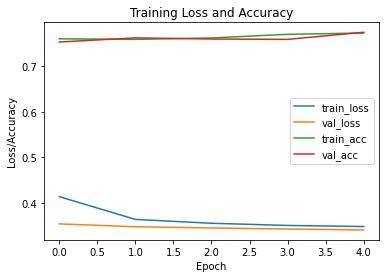

In [14]:
plt.figure()
plt.plot(hist.history["loss"], label="train_loss")
plt.plot(hist.history["val_loss"], label="val_loss")
plt.plot(hist.history["accuracy"], label="train_acc")
plt.plot(hist.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()


In [15]:
score = model.evaluate(x_test, y_test, verbose=1)
print("Test loss:", score[0])
print("Test accuracy:", score[1])


63/63 [==============================] - 0s 3ms/step - loss: 0.3357 - accuracy: 0.8279
Test loss: 0.33570045232772827
Test accuracy: 0.8278607130050659


In [16]:
idx = 0
model.predict(x_test[idx:idx+1], verbose=1)


1/1 [==============================] - 0s 86ms/step


array([[1.0139277e-04, 9.9989855e-01]], dtype=float32)

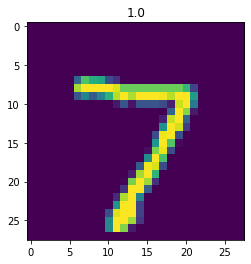

In [17]:
plt.figure()
plt.title(y_test[idx][1])
plt.imshow(np.squeeze(x_test[idx]))
plt.show()

# Exemplar Model
Create a layer with M nodes with the goal that each node is a "detector" that activates in a local region. We want:
- no detectors to fire (predict 1) when the true label is 0
- exactly one detector to fire when the true label is 1 (may be noisy)

The first goal can be met by comparing summed prediction across the outputs to 0.

The second goal can be met by either
- taking the L1 norm across the predictions to encourage sparsity
- taking the loss only on the highest valued output


In [18]:
num_exemplars = 20

In [19]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_exemplars, activation="sigmoid")
    ]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1600)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)               

## Define a custom loss class


In [29]:
class CustomExemplarLoss(keras.losses.Loss):
    def __init__(self, opt=1, name="custom_exemplar_loss"):
        super().__init__(name=name)
        self.opt = opt # Just a placeholder at the moment

    def call(self, y_true, y_pred):
        alpha = 1.0

        # mse = tf.math.reduce_mean(tf.square(y_true - y_pred))
        # reg = tf.math.reduce_mean(tf.square(0.5 - y_pred))
        # return mse + reg * self.regularization_factor

        # y_true should be 1 number (0 or 1)
        # y_pred should be N numbers (predictions)
        print('y_true:', y_true.shape)
        print('y_pred:', y_pred.shape)

        # Find the difference of each prediction from gt
        # with any luck, tf will auto expand y_true
        diff = tf.abs(y_true - y_pred)

        # Find the min difference along the last axis (columns)
        loss = tf.math.reduce_min(diff, axis=-1)

        # Encourage sparsity:
        #   when true is 0, preds are all 0
        #   when true is 1, one pred is 1
        loss_s = tf.math.reduce_sum(diff, axis=-1)

        reg = tf.math.reduce_sum(tf.square(0 - y_pred), axis=-1)

        return loss + alpha * loss_s + reg


In [30]:
model.compile(optimizer=keras.optimizers.Adam(), loss=CustomExemplarLoss(), metrics=["accuracy"])
batch_size = 128
epochs = 5

model.fit(x_train, y_train[:,1], batch_size=batch_size, epochs=epochs, validation_split=0.1)


Epoch 1/5
y_true: (None, 1)
y_pred: (None, 20)
y_true: (None, 1)
y_pred: (None, 20)
85/86 [============================>.] - ETA: 0s - loss: 24.8784 - accuracy: 0.2323y_true: (None, 1)
y_pred: (None, 20)
86/86 [==============================] - 1s 8ms/step - loss: 24.8807 - accuracy: 0.2324 - val_loss: 24.9422 - val_accuracy: 0.2353
Epoch 2/5
86/86 [==============================] - 0s 5ms/step - loss: 25.0407 - accuracy: 0.2402 - val_loss: 24.9422 - val_accuracy: 0.2353
Epoch 3/5
86/86 [==============================] - 0s 5ms/step - loss: 25.0117 - accuracy: 0.2374 - val_loss: 15.4073 - val_accuracy: 0.0033
Epoch 4/5
86/86 [==============================] - 0s 5ms/step - loss: 14.5105 - accuracy: 0.0110 - val_loss: 13.2631 - val_accuracy: 0.0000e+00
Epoch 5/5
86/86 [==============================] - 0s 5ms/step - loss: 13.2139 - accuracy: 0.0000e+00 - val_loss: 13.1613 - val_accuracy: 0.0000e+00


## Show some results
Ideally, outputs are all close to zero when true label is 0, and one output is close to 1 when true label is 1.

# TODO: Pick up here - why are some 4's 0's and some 1's?

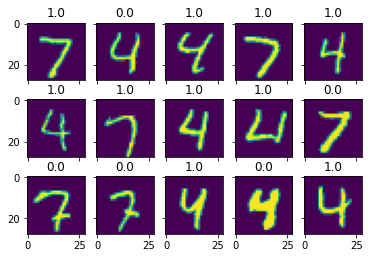

In [38]:
num_rows = 3
num_cols = 5

fig, ax = plt.subplots(num_rows, num_cols, sharex='col', sharey='row')
for i in range(num_rows):
    for j in range(num_cols):
        idx = i*num_cols + j
        ax[i, j].set_title(y_train[idx][1])
        ax[i, j].imshow(np.squeeze(x_test[idx]))


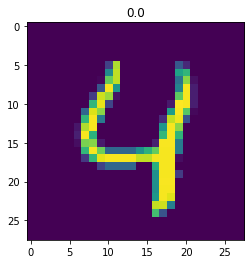

In [34]:
idx = 1

plt.figure()
plt.title(y_train[idx][1])
plt.imshow(np.squeeze(x_test[idx]))
plt.show()


[0.03499696 0.03784303 0.03598294 0.03824934 0.03877736 0.03499855
 0.03486878 0.03592682 0.03402441 0.03301944 0.03358405 0.03749658
 0.03761749 0.0362913  0.00931575 0.03651986 0.03999626 0.03155006
 0.03698789 0.18292566]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


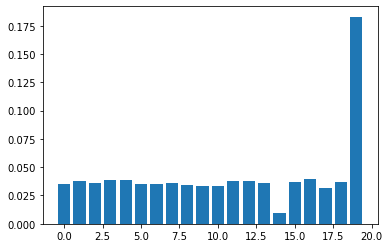

In [35]:
preds = model.predict(x_train[idx:idx+1])[0]
bins = np.arange(len(preds))
print(preds)
print(bins)
plt.bar(bins, preds)
plt.show()


1/1 [==============================] - 0s 20ms/step


TypeError: ignored

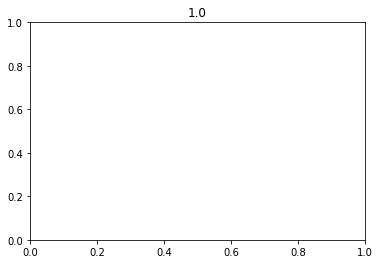

In [33]:
preds = model.predict(x_train[idx:idx+1])[0]
bins = np.arange(len(preds))
print(preds)
print(bins)
plt.bar(bins, preds)
plt.show()

